# Spectral type flagger and star physical quantities Probability Distribution Functions (star-PDF)

In [1]:
### Import libraries ###
%matplotlib inline
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lephare import statsplot as lsp

LEPHAREDIR is being set to the default cache directory:
/home/hallouin/.cache/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/home/hallouin/.cache/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/home/hallouin/.cache/lephare/runs/20251013T115331


In another script, we developped a PDFstar flagger which assumes the spectral type of a star by looking at the best fit of a onesource object over a star template. We used a 1 dimensional, and limited, sed lib which was to cover smoothly the entire specter of star spectral-types (from O to M and with a few white dwarves). 

Looking at the functionning of Lephare to determine photo-z, when we use the minimal Chi2 method, we determine the type of galaxy at a pecular redshift, so we fit a source to a 2D grid.

Aside that, there is three main quantities that determine the atmosphere of a star : Surface temperature (**Teff**), Mass or gravity (**log(g)**) and composition or metallicity (**Fe/H**).

Taking these informations into account, we can use the same logic as the one used to compute the photo-z of a source but to determine the spectral-type of a star. Hence, this time we want to use a more complete 2D or 3D grid of star sed.

Thus we pre-made a star sed library for Lephare that covers every knew type of star with those physical quantities, and run lephare onto it.

To works, it is important to have written the specs of the utilized seds either in the respective file name or in a commmented header. 

## The SED grid(s)

Note: sed grids are not perfectly square or cubic: some simulated sed are unrealistic, for example it is unsual to see a O-type star with a high metallicity. It would be a loss of time to compute the minimal Chi2 of a fit of a onesource to such a sed. Thus the sed grids are truncated at specific Teff values.

**Teff** vs **log(g)** vs **Fe/H**

In [2]:
### sed grid class

class SED_GRID:
    def __init__(self, list_path):
        """Load SED list."""
        sed_list = []
        with open(list_path, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('#') or not line:
                    continue
                filepath = line.split()[0]
                sp_type = filepath.split('/')[-1].replace('.sed', "")
                sed_list.append(sp_type)
        self.sed_list = sed_list
        self.sed_grid = None

    def build(self):
        """Build the sed grid [Id, Teff, logg, FeH] from filenames."""
        pattern = r"Teff([-\d\.]+)_logg([-\d\.]+)_FeH([-\d\.]+)"
        sed_grid = []
        for Id, s in enumerate(self.sed_list):
            match = re.search(pattern, s)
            if match:
                Teff, logg, FeH = match.groups()
                Teff, logg, FeH = float(Teff), float(logg), float(FeH)
                sed_grid.append([Id, Teff, logg, FeH])
        self.sed_grid = np.array(sed_grid)
        return self.sed_grid

    def plot(self, cmap='gnuplot'):
        """Plot 3D SED grid with color depending on FeH."""
        if self.sed_grid is None:
            raise ValueError("Call make_sed_grid before plot.")

        Teff, logg, FeH = self.sed_grid[:, 1], self.sed_grid[:, 2], self.sed_grid[:, 3]

        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(projection='3d')

        # Couleur selon la métallicité
        sc = ax.scatter(
            Teff, logg, FeH,
            c=FeH, cmap=cmap,
            alpha=0.8, s=10, edgecolor="none"
        )

        # Colorbar
        cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink=0.8)
        cbar.set_label('[Fe/H]', rotation=270, labelpad=15)

        ax.set_xlabel('Teff [K]')
        ax.set_ylabel('log(g)')
        ax.set_zlabel('[Fe/H]')
        ax.set_title("SED Grid Colored by Metallicity")

        # Optionnel : meilleure orientation par défaut
        ax.view_init(elev=20, azim=-45)

        plt.tight_layout()
        plt.show()

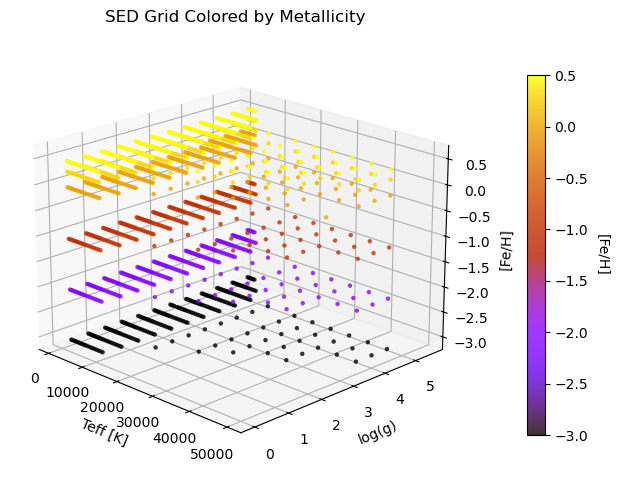

In [3]:
# %matplotlib widget
sed_grid_path = '/home/hallouin/Documents/t_hall/lephare/simulated_star_sed/bt_spectra/bt_star_sed_full.list'
sed_grid_init = SED_GRID(sed_grid_path)
sed_grid = sed_grid_init.build()
sed_grid_init.plot()

## Retrieving full star Chi2 distribution

During its processing, the only way to identify which template(s) has been used to compute the quantities relative to a onesource it's their Id. This Id is assigned when creating the sed library (with the SedLib part of the code), and is useful to retrieve the sed during or at the end of the process. 

A notable difference between the PDZ and the star-PDF is that the first one is computed from a grid that has been created thanks to the MagLab part of the code, while the star-PDF will be made from a already full 2D or 3D grid. Which means that we need to "remember" the Id of each seds to re-order them in the good way to have a smooth functionning PDF.



So first we need functions to retrieve the physical quanities relative to a sed (**Teff**, **log(g)** and **Fe/H**) thanks to its Id.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

class STAR_PDF:
    def __init__(self, sed_grid_obj):
        if sed_grid_obj.sed_grid is None:
            raise ValueError("SED_GRID: call build() before using STAR_PDF_VISUALIZER.")

        self.sed_grid = sed_grid_obj.sed_grid   # base grid
        self.chi2_grid = None                   # will be built later

    # ------------------------------------------------------------------
    def build_chi2_grid(self, chi2_array):
        """Attach chi2 array to SED grid."""
        if len(chi2_array) != len(self.sed_grid):
            raise ValueError("chi2 array length does not match sed_grid length.")

        self.chi2_grid = np.column_stack((self.sed_grid, chi2_array))
        return self.chi2_grid

    # ------------------------------------------------------------------
    def project_min_chi2(self, xaxis="Teff", yaxis=None, to_prob=False, fixed=None):
        """
        Project Chi² parallel to one or two axes.
        Uses self.chi2_grid automatically.
        """
        if self.chi2_grid is None:
            raise ValueError("Call build_chi2_grid before projecting.")

        grid = self.chi2_grid
        columns = ["Id", "Teff", "logg", "FeH", "Chi2"]
        col_idx = {k: i for i, k in enumerate(columns)}

        # 1) Apply fixed filters
        mask = np.ones(len(grid), dtype=bool)
        if fixed:
            for key, val in fixed.items():
                mask &= np.isclose(grid[:, col_idx[key]], val)
            grid = grid[mask]
            if len(grid) == 0:
                raise ValueError("No grid point matches the given fixed conditions.")

        xcol = col_idx[xaxis]

        if yaxis:   # ----------- 2D PROJECTION -------------
            ycol = col_idx[yaxis]

            X_vals = np.unique(grid[:, xcol])
            Y_vals = np.unique(grid[:, ycol])
            Z = np.full((len(Y_vals), len(X_vals)), np.nan)

            for i, xv in enumerate(X_vals):
                for j, yv in enumerate(Y_vals):
                    mask_xy = np.isclose(grid[:, xcol], xv) & np.isclose(grid[:, ycol], yv)
                    if np.any(mask_xy):
                        Z[j, i] = np.nanmin(grid[mask_xy, -1])

            if to_prob:
                Zmin = np.nanmin(Z)
                Z = np.exp(-0.5 * (Z - Zmin))

            return X_vals, Y_vals, Z

        else:       # ----------- 1D PROJECTION -------------
            X_vals = np.unique(grid[:, xcol])
            Z = np.full(len(X_vals), np.nan)

            for i, xv in enumerate(X_vals):
                mask_x = np.isclose(grid[:, xcol], xv)
                if np.any(mask_x):
                    Z[i] = np.nanmin(grid[mask_x, -1])

            if to_prob:
                Zmin = np.nanmin(Z)
                Z = np.exp(-0.5 * (Z - Zmin))

            return X_vals, Z

    # ------------------------------------------------------------------
    def plot_min_chi2(self, xaxis="Teff", yaxis=None, to_prob=False,
                      full=False, cmap='gnuplot', fixed=None):

        if self.chi2_grid is None:
            raise ValueError("Call build_chi2_grid before plotting.")

        grid = self.chi2_grid  # just to avoid rewriting this everywhere

        # ---------- FULL CORNER-PLOT ----------
        if full:
            axes = ["Teff", "logg", "FeH"]
            n = len(axes)

            # Uniform axes
            limits = {}
            for ax in axes:
                limits[ax] = np.unique(grid[:, {"Teff": 1, "logg": 2, "FeH": 3}[ax]])
            
            fig = plt.figure(figsize=(8, 8))
            gs = plt.GridSpec(n, n, wspace=0.0, hspace=0.0)

            for i in range(n):  # line
                for j in range(n):  # col
                    if j > i:
                        continue
                    ax = fig.add_subplot(gs[i, j])

                    if i == j:
                        # --- PDF 1D ---
                        X, Z = self.project_min_chi2(xaxis=axes[j], to_prob=to_prob, fixed=fixed)
                        ax.plot(X, Z, color='black', lw=1)
                        # ax.fill_between(X, Z, color='C0', alpha=0.4)
                        ax.set_xlim(limits[axes[j]].min(), limits[axes[j]].max())
                        ax.set_ylim(Z.min() * 0.95, Z.max() * 1.05)
                        if i < n - 1:
                            ax.set_xticklabels([])
                        if i != 0:
                            ax.yaxis.tick_right()
                        else:
                            ax.set_xlabel(axes[j])

                    else:
                        # --- PDF 2D ---
                        X, Y, Z = self.project_min_chi2(xaxis=axes[j], yaxis=axes[i], fixed=fixed)
                        if to_prob:
                            Z = np.exp(-0.5 * (Z - np.nanmin(Z)))
                        im = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
                        ax.set_xlim(limits[axes[j]].min(), limits[axes[j]].max())
                        ax.set_ylim(limits[axes[i]].min(), limits[axes[i]].max())
                        if i < n - 1:
                            ax.set_xticklabels([])
                        else:
                            ax.set_xlabel(axes[j])
                        if j > 0:
                            ax.set_yticklabels([])
                        else:
                            ax.set_ylabel(axes[i])

            # Colorbar
            cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label("Probability" if to_prob else "min(χ²)")
            plt.subplots_adjust(left=0.08, right=0.9, top=0.9, bottom=0.08)
            plt.show()
            return


        # --- Single plot mode
        if yaxis:
            X, Y, Z = self.project_min_chi2(xaxis, yaxis, to_prob=to_prob, fixed=fixed)
            plt.figure(figsize=(6, 4))
            plt.pcolormesh(X, Y, Z, shading='auto')
            plt.colorbar(label="Probability" if to_prob else "min(Chi²)")
            plt.xlabel(xaxis)
            plt.ylabel(yaxis)
            plt.title(f"Minimized Chi² map")
            plt.show()
        else:
            X, Z = self.project_min_chi2(xaxis, to_prob=to_prob, fixed=fixed)
            plt.figure(figsize=(6, 3))
            plt.plot(X, Z, marker='o', lw=1)
            plt.xlabel(xaxis)
            plt.ylabel("Probability" if to_prob else "min(Chi²)")
            plt.title("Minimized Chi² PDF")
            plt.grid(True)
            plt.show()

    def plot_full_chi2(self, cmap='gnuplot'):
        """Plot 3D SED grid with color depending on FeH."""
        grid = self.chi2_grid  # just to avoid rewriting this everywhere
        print(grid)
        Teff, logg, FeH = grid[:, 1], grid[:, 2], grid[:, 3]
        Chi2 = grid[:, 4]
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(projection='3d')
        # Coulor as a function of Chi2
        sc = ax.scatter(
            Teff, logg, FeH,
            c=Chi2, cmap=cmap,
            alpha=0.8, s=10, edgecolor="none"
        )

        # Colorbar
        cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink=0.8)
        cbar.set_label('Chi2', rotation=270, labelpad=15)

        ax.set_xlabel('Teff [K]')
        ax.set_ylabel('log(g)')
        ax.set_zlabel('[Fe/H]')
        ax.set_title("SED Grid Colored by Metallicity")
 
        # Optionnel : meilleure orientation par défaut
        ax.view_init(elev=20, azim=-45)
 
        plt.tight_layout()
        plt.show()

    def best_output(self):
        grid = self.chi2_grid
        best_sed_id = np.argmin(grid[:,4])
        chi2_best = min(grid[:,4])
        Teff_best = grid[best_sed_id, 1]
        logg_best = grid[best_sed_id, 2]
        FeH_best = grid[best_sed_id, 3]
        
        chisec_grid = np.delete(grid, best_sed_id, axis=0)
        sec_best_sed_id = np.argmin(chisec_grid[:,4])
        sec_chi2_best = min(chisec_grid[:,4])
        sec_Teff_best = chisec_grid[sec_best_sed_id, 1]
        sec_logg_best = chisec_grid[sec_best_sed_id, 2]
        sec_FeH_best = chisec_grid[sec_best_sed_id, 3]
        sec_best_sed_id = sec_best_sed_id + 1 if sec_best_sed_id >= best_sed_id else sec_best_sed_id
        return [best_sed_id, Teff_best, logg_best, FeH_best, chi2_best, 
                sec_best_sed_id, sec_Teff_best, sec_logg_best, sec_FeH_best, sec_chi2_best]

## PDF examples

In [17]:
# chi2_values_path = "/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DESstars_BT_DES_full_PDFstar.prob"
# chi2_values_path = "/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DC1_BT_LSST_full_PDFstar.prob"
chi2_values_path = "/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/dp02_dc2_62_BT_LSST_full_PDFstar.prob"
chi2_values = np.loadtxt(chi2_values_path, max_rows=1000) 

/tmp/ipykernel_6169/3114834482.py:4: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=1000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  chi2_values = np.loadtxt(chi2_values_path, max_rows=1000)


In [ ]:
star_pdf = STAR_PDF(sed_grid_init)
chi2_grid = star_pdf.build_chi2_grid(chi2_values[56,1:])

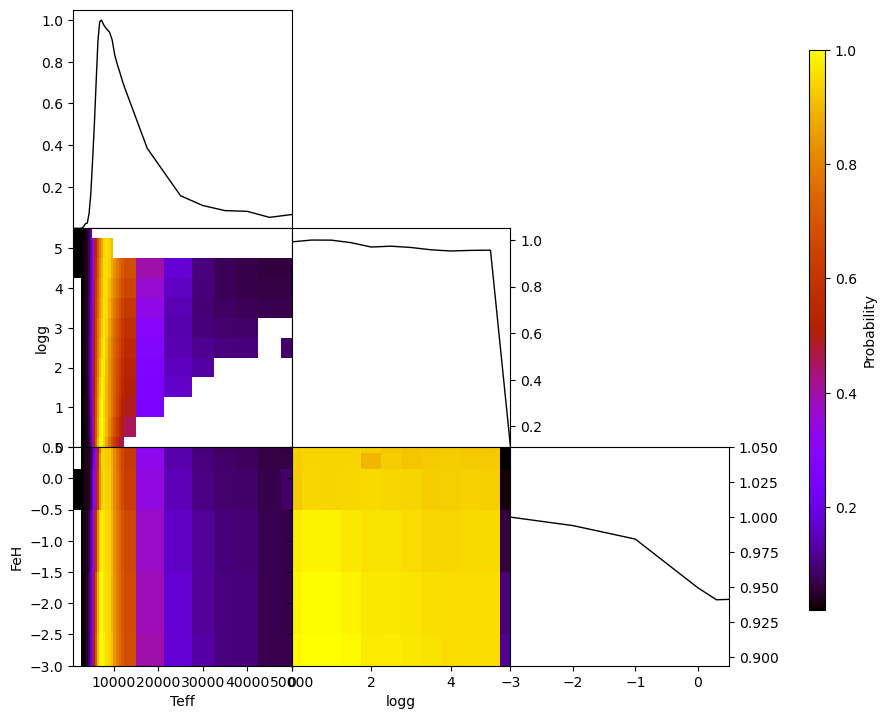

In [30]:
star_pdf.plot_min_chi2(to_prob=True, full=True)#, fixed={"FeH": 0.5, "Teff": 7200})

[[ 0.0000e+00  1.0200e+04  0.0000e+00 -1.0000e+00  3.3725e+00]
 [ 1.0000e+00  1.0200e+04  0.0000e+00 -2.0000e+00  3.2948e+00]
 [ 2.0000e+00  1.0200e+04  0.0000e+00 -3.0000e+00  3.2868e+00]
 ...
 [ 1.6190e+03  9.6000e+03  5.0000e+00  0.0000e+00  2.5514e+00]
 [ 1.6200e+03  9.6000e+03  5.0000e+00  3.0000e-01  2.5563e+00]
 [ 1.6210e+03  9.6000e+03  5.0000e+00  5.0000e-01  2.5555e+00]]


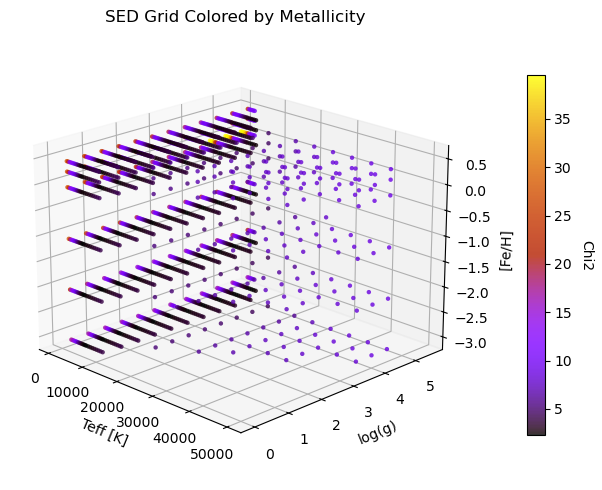

In [31]:
star_pdf.plot_full_chi2()

## PDF Analyzer - Computing statistical quantities describing the PDFs of onesource

Now that we obtained the PDFs (or Chi2 distribution) of every sources that passed through Lephare, we're getting close to build a classifier.

Looking at the precedent results, we clearly see visual differences between star "starPDF" and galaxy "starPDF", the first ones generally looking better than the other. Thus we need to turn this visual results into statistical tools to make our binarry classifier.

The STAR_PDF_ANALYZER class is constitued as follow:

 - **Preliminary functions:** _init_, _make_prob3d, _project_1d, project_2d ;
 - **1D PDF analysis functions:** npeaks1D, peak_ratio_1D, std_1D ;
 - **2D PDF analysis functions:** cov_2d, area_highprob_2d ;
 - **global PDF analysis functions:** entropy, concentration, delta_chi2 ;
 - **compute_all_features** 

 These functions are typical statistical tools for PDF, we will identify which ones are the most relevant.

In [5]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d, griddata, RegularGridInterpolator
from scipy.ndimage import gaussian_filter


class STAR_PDF_ANALYZER:
    """
    Analyzer for chi2_grid (Nx5 array: [Id, Teff, logg, FeH, Chi2]).
    Option A: interpolation is done on chi2 (not on probabilities).
    - to_prob_3D: if True, compute global P3 (full-grid PDF) once at init
    - to_prob: if True, projectors return normalized probabilities per projection
    """

    def __init__(self, chi2_grid, to_prob=True, to_prob_3D=False, oversample=1.0, nmax=800):
        chi2_grid = np.asarray(chi2_grid)
        if chi2_grid.ndim != 2 or chi2_grid.shape[1] < 5:
            raise ValueError("chi2_grid must be shape (N,>=5) with columns [Id,Teff,logg,FeH,Chi2].")

        self.grid = chi2_grid.copy()
        self.to_prob_3D = bool(to_prob_3D)
        self.to_prob = bool(to_prob)

        # indices
        self.col = {"Id": 0, "Teff": 1, "logg": 2, "FeH": 3, "Chi2": 4}

        # global quantities
        self.chi2_min_global = float(np.nanmin(self.grid[:, self.col["Chi2"]]))
        self.P3 = None
        if self.to_prob_3D:
            self._make_prob3d()

        # caches and interpolation settings
        self._regular_cache = {}   # axis -> dict: {"vals": array, "regular": bool}
        self._oversample = float(oversample)
        self._nmax = int(nmax)

    # --------------------------
    # Internal helpers: PDFs
    # --------------------------
    def _make_prob3d(self):
        """Compute full-grid probability P3 normalized."""
        chi2 = self.grid[:, self.col["Chi2"]].astype(float)
        dchi2 = chi2 - np.nanmin(chi2)
        with np.errstate(over="ignore", invalid="ignore"):
            P = np.exp(-0.5 * dchi2)
        P[np.isnan(P)] = 0.0
        s = P.sum()
        if s <= 0:
            P = np.zeros_like(P)
        else:
            P = P / s
        self.P3 = P
        return P

    # --------------------------
    # Regular grid utilities
    # --------------------------
    def _unique_sorted_axis(self, axis):
        vals = np.unique(self.grid[:, self.col[axis]])
        vals = np.sort(vals)
        return vals

    def _is_regular_axis(self, vals, rtol=1e-8):
        """Return True if axis values are regularly spaced (within rtol)."""
        if vals.size < 3:
            return True
        d = np.diff(vals)
        # consider only positive diffs
        dpos = d[d > 0]
        if dpos.size == 0:
            return True
        return np.allclose(dpos, dpos[0], rtol=rtol, atol=0)

    def _optimal_regular_grid(self, vals):
        """Build regular grid using dx = min positive difference (pas minimum observed)."""
        vals = np.sort(np.unique(vals))
        if vals.size < 2:
            return vals.copy()
        d = np.diff(vals)
        dpos = d[d > 0]
        if dpos.size == 0:
            return vals.copy()
        dx_min = float(np.min(dpos))
        xmin, xmax = float(vals[0]), float(vals[-1])
        # number of steps based on dx_min and oversampling factor
        n = int(np.ceil(self._oversample * (xmax - xmin) / dx_min)) + 1
        n = max(2, min(n, self._nmax))
        grid = np.linspace(xmin, xmax, n)
        return grid

    def _get_regular_axis(self, axis):
        """Return cached regular grid for axis or build it. Also return flag regular."""
        if axis in self._regular_cache:
            return self._regular_cache[axis]["vals"], self._regular_cache[axis]["regular"]

        vals = self._unique_sorted_axis(axis)
        regular = self._is_regular_axis(vals)
        if regular:
            grid = vals.copy()
        else:
            grid = self._optimal_regular_grid(vals)
        self._regular_cache[axis] = {"vals": grid, "regular": regular}
        return grid, regular

    # --------------------------
    # Regularize (interpolate) 1D and 2D on chi2 then convert if needed
    # --------------------------
    def _regularize_1d_chi2(self, X, Zchi2, axis):
        """
        Inputs:
          X : original axis values (1D)
          Zchi2 : values (min-chi2 per X) corresponding to X
        Output:
          Xr, Zr_chi2  on regularized grid for axis (chi2 interpolated)
        """
        X = np.asarray(X)
        # remove nan entries
        good = ~np.isnan(Zchi2)
        if np.sum(good) == 0:
            return np.array([]), np.array([])

        Xg = X[good]
        Zg = np.asarray(Zchi2)[good]

        grid, is_reg = self._get_regular_axis(axis)
        if is_reg:
            # original grid is regular: but might be coarser than unique Xg
            # if Xg equals grid then just return aligned arrays
            # we will interpolate to ensure alignment
            if np.array_equal(np.unique(Xg), grid):
                # build Zr aligned to grid
                f = interp1d(Xg, Zg, bounds_error=False, fill_value=np.nan)
                Zr = f(grid)
                return grid, Zr
            else:
                f = interp1d(Xg, Zg, bounds_error=False, fill_value=np.nan)
                Zr = f(grid)
                return grid, Zr
        else:
            # interpolate onto the constructed fine grid
            f = interp1d(Xg, Zg, kind="linear", bounds_error=False, fill_value=np.nan)
            Zr = f(grid)
            return grid, Zr

    def _regularize_2d_chi2(self, X, Y, Zchi2, xaxis, yaxis):
        """
        Inputs:
           X (1d array of x grid), Y (1d array of y grid), Zchi2 (2D shaped (len(Y),len(X)))
        Output:
           Xr, Yr, Zr_chi2 on regular grids for xaxis and yaxis
        """
        X = np.asarray(X); Y = np.asarray(Y); Zchi2 = np.array(Zchi2)
        # build target axes
        Xr, regx = self._get_regular_axis(xaxis)
        Yr, regy = self._get_regular_axis(yaxis)

        # If both regular and matching, return as-is (but ensure shape ordering)
        if regx and regy:
            # If X and Y already equal Xr and Yr shapes, return them
            if np.array_equal(np.unique(X), Xr) and np.array_equal(np.unique(Y), Yr):
                return Xr, Yr, Zchi2
            # else we'll interpolate anyway to Xr,Yr
        # Flatten original grid points
        # create points and values for griddata (use centers from X,Y arrays)
        xv, yv = np.meshgrid(X, Y)  # shape (len(Y), len(X)) -> positions correspond to Zchi2 shape
        pts = np.column_stack((xv.ravel(), yv.ravel()))
        vals = Zchi2.ravel()
        # create target grid
        XI, YI = np.meshgrid(Xr, Yr)
        # interpolating chi2 values (could have NaNs) -> use 'linear' then fill missing with nearest
        Zr = griddata(pts, vals, (XI, YI), method='linear')
        # fill remaining nan with nearest
        nanmask = np.isnan(Zr)
        if np.any(nanmask):
            Zr_nearest = griddata(pts, vals, (XI, YI), method='nearest')
            Zr[nanmask] = Zr_nearest[nanmask]
        return Xr, Yr, Zr

    # --------------------------
    # Projection on original grid (min chi2 over other dims)
    # --------------------------
    def _project_min_chi2_1d_raw(self, axis, fixed=None):
        """Return X_vals (unique) and min_chi2 array Zchi2 per X (no interpolation)."""
        idx = self.col[axis]
        mask = np.ones(len(self.grid), dtype=bool)
        if fixed:
            for k, v in fixed.items():
                if k not in self.col:
                    raise ValueError(f"Unknown fixed axis '{k}'")
                mask &= np.isclose(self.grid[:, self.col[k]], v)
        sub = self.grid[mask]
        if sub.size == 0:
            return np.array([]), np.array([])

        X_vals = np.unique(sub[:, idx])
        X_vals.sort()
        Z = np.full(len(X_vals), np.nan)
        for i, xv in enumerate(X_vals):
            sel = np.isclose(sub[:, idx], xv)
            if np.any(sel):
                Z[i] = np.nanmin(sub[sel, self.col["Chi2"]])
        return X_vals, Z

    def _project_min_chi2_2d_raw(self, xaxis, yaxis, fixed=None):
        """Return X_vals, Y_vals and Zchi2 (shape len(Y),len(X)) raw (without interpolation)."""
        xi = self.col[xaxis]; yi = self.col[yaxis]
        mask = np.ones(len(self.grid), dtype=bool)
        if fixed:
            for k, v in fixed.items():
                if k not in self.col:
                    raise ValueError(f"Unknown fixed axis '{k}'")
                mask &= np.isclose(self.grid[:, self.col[k]], v)
        sub = self.grid[mask]
        if sub.size == 0:
            return np.array([]), np.array([]), np.array([[]])

        X_vals = np.unique(sub[:, xi]); X_vals.sort()
        Y_vals = np.unique(sub[:, yi]); Y_vals.sort()
        Z = np.full((len(Y_vals), len(X_vals)), np.nan)
        for i, xv in enumerate(X_vals):
            for j, yv in enumerate(Y_vals):
                sel = np.isclose(sub[:, xi], xv) & np.isclose(sub[:, yi], yv)
                if np.any(sel):
                    Z[j, i] = np.nanmin(sub[sel, self.col["Chi2"]])
        return X_vals, Y_vals, Z

    # --------------------------
    # Public projectors that return either chi2 or probability on regularized grid
    # --------------------------
    def project_1d(self, axis, to_prob=None, fixed=None):
        """
        Return Xr, Z where:
         - Xr: regularized axis grid
         - Z: if to_prob True -> normalized probability (sum=1); else -> chi2 (min chi2 per X)
        """
        if to_prob is None:
            to_prob = self.to_prob

        Xraw, Zchi2_raw = self._project_min_chi2_1d_raw(axis, fixed=fixed)
        if Xraw.size == 0:
            return np.array([]), np.array([])

        Xr, Zchi2 = self._regularize_1d_chi2(Xraw, Zchi2_raw, axis)

        if Xr.size == 0:
            return np.array([]), np.array([])

        if to_prob:
            # convert chi2 -> probability with local minimum
            if np.all(np.isnan(Zchi2)):
                return Xr, np.zeros_like(Zchi2)
            dchi = Zchi2 - np.nanmin(Zchi2)
            with np.errstate(over="ignore", invalid="ignore"):
                P = np.exp(-0.5 * dchi)
            P[np.isnan(P)] = 0.0
            s = np.nansum(P)
            if s > 0:
                P = P / s
            else:
                P = np.zeros_like(P)
            return Xr, P
        else:
            return Xr, Zchi2

    def project_2d(self, xaxis, yaxis, to_prob=None, fixed=None):
        """
        Return Xr, Yr, Z where:
         - Xr, Yr: regularized axis grids
         - Z: if to_prob True -> normalized probability (sum ~1); else -> chi2 map (min chi2 per cell)
        """
        if to_prob is None:
            to_prob = self.to_prob

        Xraw, Yraw, Zchi2_raw = self._project_min_chi2_2d_raw(xaxis, yaxis, fixed=fixed)
        if Xraw.size == 0 or Yraw.size == 0:
            return np.array([]), np.array([]), np.array([[]])

        Xr, Yr, Zchi2 = self._regularize_2d_chi2(Xraw, Yraw, Zchi2_raw, xaxis, yaxis)

        if Xr.size == 0 or Yr.size == 0:
            return np.array([]), np.array([]), np.array([[]])

        if to_prob:
            if np.all(np.isnan(Zchi2)):
                return Xr, Yr, np.zeros_like(Zchi2)
            dchi = Zchi2 - np.nanmin(Zchi2)
            with np.errstate(over="ignore", invalid="ignore"):
                P = np.exp(-0.5 * dchi)
            P[np.isnan(P)] = 0.0
            s = np.nansum(P)
            if s > 0:
                P = P / s
            else:
                P = np.zeros_like(P)
            return Xr, Yr, P
        else:
            return Xr, Yr, Zchi2

    # --------------------------
    # Metrics (1D)
    # --------------------------
    def npeaks_1d(self, axis, threshold=0.2, fixed=None):
        X, Z = self.project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        # if Z is probability -> find peaks directly
        if self.to_prob:
            arr = Z
            height = threshold * np.nanmax(arr)
            peaks, _ = find_peaks(arr, height=height)
            return int(len(peaks))
        else:
            arr = -Z
            height = threshold * np.nanmax(arr)
            peaks, _ = find_peaks(arr, height=height)
            return int(len(peaks))

    def peakratio_1d(self, axis, fixed=None):
        X, Z = self.project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        mx = np.nanmax(Z)
        if mx == 0:
            return -99
        return float(np.nanmean(Z) / mx)

    def std_1d(self, axis, fixed=None):
        X, Z = self.project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        if not self.to_prob:
            # convert to probability-like weights
            if np.all(np.isnan(Z)):
                return -99
            dchi = Z - np.nanmin(Z)
            with np.errstate(over="ignore", invalid="ignore"):
                W = np.exp(-0.5 * dchi)
            W[np.isnan(W)] = 0.0
            s = np.nansum(W)
            if s > 0:
                W = W / s
            else:
                W = np.zeros_like(W)
        else:
            W = Z.copy()
        if np.nansum(W) <= 0:
            return -99
        mean = np.nansum(X * W)
        var = np.nansum(((X - mean) ** 2) * W)
        return float(np.sqrt(var))

    # --------------------------
    # Metrics (2D)
    # --------------------------
    def cov_2d(self, xaxis, yaxis, fixed=None):
        X, Y, P = self.project_2d(xaxis, yaxis, to_prob=self.to_prob, fixed=fixed)
        if P.size == 0:
            return (-99, -99, -99, -99)
        Xg, Yg = np.meshgrid(X, Y)
        W = np.array(P, dtype=float)
        tot = np.nansum(W)
        if tot <= 0:
            return (-99, -99, -99, -99)
        W = W / tot
        x_flat = Xg.ravel(); y_flat = Yg.ravel(); w_flat = W.ravel()
        good = w_flat > 0
        if np.sum(good) == 0:
            return (-99, -99, -99, -99)
        x_flat = x_flat[good]; y_flat = y_flat[good]; w_flat = w_flat[good]
        mean_x = np.sum(x_flat * w_flat); mean_y = np.sum(y_flat * w_flat)
        cov_xx = np.sum(w_flat * (x_flat - mean_x) ** 2)
        cov_yy = np.sum(w_flat * (y_flat - mean_y) ** 2)
        cov_xy = np.sum(w_flat * (x_flat - mean_x) * (y_flat - mean_y))
        cov_mat = np.array([[cov_xx, cov_xy], [cov_xy, cov_yy]])
        try:
            eig = np.linalg.eigvalsh(cov_mat)
            eig = np.maximum(eig, 1e-300)
            axis_ratio = float(np.sqrt(eig[-1] / eig[0])) if eig[0] > 0 else float(np.inf)
        except Exception:
            axis_ratio = -99
        return float(cov_xx), float(cov_yy), float(cov_xy), float(axis_ratio)

    def area_highprob_2d(self, xaxis, yaxis, threshold=0.5, fixed=None):
        X, Y, P = self.project_2d(xaxis, yaxis, to_prob=self.to_prob, fixed=fixed)
        if P.size == 0:
            return -99.0
        Pmax = np.nanmax(P)
        if Pmax <= 0:
            return 0.0
        mask = P >= (threshold * Pmax)
        valid = ~np.isnan(P)
        if np.sum(valid) == 0:
            return -99.0
        frac = np.sum(mask & valid) / np.sum(valid)
        return float(frac)

    # --------------------------
    # Global metrics
    # --------------------------
    def entropy(self):
        if self.P3 is None:
            # if P3 not precomputed, compute from chi2 on the fly
            self._make_prob3d()
        P = np.array(self.P3, dtype=float)
        mask = P > 0
        if np.sum(mask) == 0:
            return -99.0
        H = -np.sum(P[mask] * np.log(P[mask]))
        return float(H)

    def concentration(self, delta_chi2=1.0):
        chi2 = self.grid[:, self.col["Chi2"]].astype(float)
        if self.P3 is None:
            self._make_prob3d()
        mask = chi2 <= (self.chi2_min_global + float(delta_chi2))
        if np.sum(mask) == 0:
            return 0.0
        return float(np.sum(self.P3[mask]))

    def delta_chi2(self):
        chi2 = np.array(self.grid[:, self.col["Chi2"]], dtype=float)
        if chi2.size < 2:
            return -99.0
        sorted_chi = np.sort(chi2)
        return float(sorted_chi[1] - sorted_chi[0])

    # --------------------------
    # Main entry: compute all features
    # --------------------------
    def compute_all(self, fixed=None):
        """
        Compute all requested features and return as dict.
        fixed: optional dict to restrict projection (e.g. {"FeH":0.0})
        """
        feats = {}
        for ax in ["Teff", "logg", "FeH"]:
            feats[f"npeaks_{ax}"] = self.npeaks_1d(ax, threshold=0.2, fixed=fixed)
            feats[f"peakratio_{ax}"] = self.peakratio_1d(ax, fixed=fixed)
            feats[f"std_{ax}"] = self.std_1d(ax, fixed=fixed)

        pairs = [("Teff", "logg"), ("Teff", "FeH"), ("logg", "FeH")]
        for x, y in pairs:
            cov_xx, cov_yy, cov_xy, axis_ratio = self.cov_2d(x, y, fixed=fixed)
            feats[f"cov_{x}_{y}_xx"] = cov_xx
            feats[f"cov_{x}_{y}_yy"] = cov_yy
            feats[f"cov_{x}_{y}_xy"] = cov_xy
            feats[f"axisratio_{x}_{y}"] = axis_ratio
            feats[f"area_{x}_{y}_p50"] = self.area_highprob_2d(x, y, threshold=0.5, fixed=fixed)
            feats[f"area_{x}_{y}_p90"] = self.area_highprob_2d(x, y, threshold=0.9, fixed=fixed)

        feats["entropy"] = self.entropy()
        feats["concentration_dchi2_1"] = self.concentration(delta_chi2=1.0)
        feats["delta_chi2"] = self.delta_chi2()
        return feats



In [9]:
# Testing the class
star_pdf_analyzer = STAR_PDF_ANALYZER(chi2_grid)
star_pdf_features = star_pdf_analyzer.compute_all()
star_pdf_features

{'npeaks_Teff': 1,
 'peakratio_Teff': 0.10115198906537107,
 'std_Teff': 12569.118261599602,
 'npeaks_logg': 1,
 'peakratio_logg': 0.9746445605081479,
 'std_logg': 1.7095765390477362,
 'npeaks_FeH': 0,
 'peakratio_FeH': 0.9175535759329103,
 'std_FeH': 1.0640288073843693,
 'cov_Teff_logg_xx': 99806567.39533147,
 'cov_Teff_logg_yy': 2.3395947197984714,
 'cov_Teff_logg_xy': 1818.6958097025527,
 'axisratio_Teff_logg': 6578.201227727489,
 'area_Teff_logg_p50': 0.04099462365591398,
 'area_Teff_logg_p90': 0.012096774193548387,
 'cov_Teff_FeH_xx': 159070708.84819546,
 'cov_Teff_FeH_yy': 1.1251400021488323,
 'cov_Teff_FeH_xy': 292.9819061093419,
 'axisratio_Teff_FeH': 11893.125332855252,
 'area_Teff_FeH_p50': 0.04711375212224109,
 'area_Teff_FeH_p90': 0.007640067911714771,
 'cov_logg_FeH_xx': 2.885931399488695,
 'cov_logg_FeH_yy': 1.1295567093760703,
 'cov_logg_FeH_xy': -0.019293335617689127,
 'axisratio_logg_FeH': 1.5986215641822574,
 'area_logg_FeH_p50': 1.0,
 'area_logg_FeH_p90': 0.4298245614

## Distributions

Chi2_best, sed_best... among the source sample

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class SAMPLE_ANALYZER:
    def __init__(self, chi2_path, sed_grid_path, nrow=None):

        # -------------------------------
        # Load raw file as strings (FAST)
        # -------------------------------
        raw = np.loadtxt(chi2_path, max_rows=nrow, dtype=str)

        # Exact integer IDs (no float64 precision loss)
        self.ids = raw[:, 0].astype("int64")

        # Vectorized float conversion
        self.chi2_values = raw[:, 1:].astype(float)

        # SED grid
        self.sed_grid_obj = SED_GRID(sed_grid_path)
        self.sed_grid = self.sed_grid_obj.build()

    # ----------------------------------------------------------------------

    def best_fit_distribution(self, n_rows=None):
        star_pdf = STAR_PDF(self.sed_grid_obj)
        data = []

        N = n_rows if n_rows is not None else len(self.ids)

        for i in range(N):
            # Build chi2 grid for this source
            _ = star_pdf.build_chi2_grid(self.chi2_values[i, :])

            df = star_pdf.best_output()   # returns values array/list

            data.append([self.ids[i]] + df)

        self.sample_df = pd.DataFrame(
            data,
            columns=[
                'source_id',
                'best_sed_id', 'Teff_best', 'logg_best', 'FeH_best', 'chi2_best',
                'sec_best_sed_id', 'sec_Teff_best', 'sec_logg_best', 'sec_FeH_best', 'sec_chi2_best'
            ]
        )

        return self.sample_df

    # ----------------------------------------------------------------------

    def stat_feature_distribution(self, n_rows=None):
        rows = []

        N = n_rows if n_rows is not None else len(self.ids)

        for i in range(N):

            star_pdf = STAR_PDF(self.sed_grid_obj)
            chi2_grid = star_pdf.build_chi2_grid(self.chi2_values[i, :])

            analyzer = STAR_PDF_ANALYZER(chi2_grid)
            feats = analyzer.compute_all()      # returns dict

            # Exact ID added here
            feats["source_id"] = self.ids[i]

            rows.append(feats)

        self.feature_df = pd.DataFrame(rows)

        return self.feature_df

    # ----------------------------------------------------------------------

    def plot_best(self, axis='chi2_best'):
        plt.figure()
        plt.hist(self.sample_df[axis], bins=50)
        plt.xlabel(axis)
        plt.ylabel("N")
        plt.show()

In [12]:
# chi2_values_path = "/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DESstars_BT_DES_full_PDFstar.prob"
# chi2_values_path = "/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DC1_BT_LSST_full_PDFstar.prob"
chi2_values_path = "/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/dp02_dc2_62_BT_LSST_full_PDFstar.prob"
sample_analyzer = SAMPLE_ANALYZER(chi2_values_path, sed_grid_path, nrow=10000)

/tmp/ipykernel_7073/1727001256.py:12: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=10000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt(chi2_path, max_rows=nrow, dtype=str)


In [13]:
training_sample_features = sample_analyzer.stat_feature_distribution()

In [14]:
training_sample_features.to_csv('/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/training_sample_features.csv', index=False)

In [ ]:
# training_sample_features = pd.read_csv('/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/training_sample_features.csv')

/home/hallouin/Documents/t_hall/lephare/src/lephare/statsplot.py:556: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


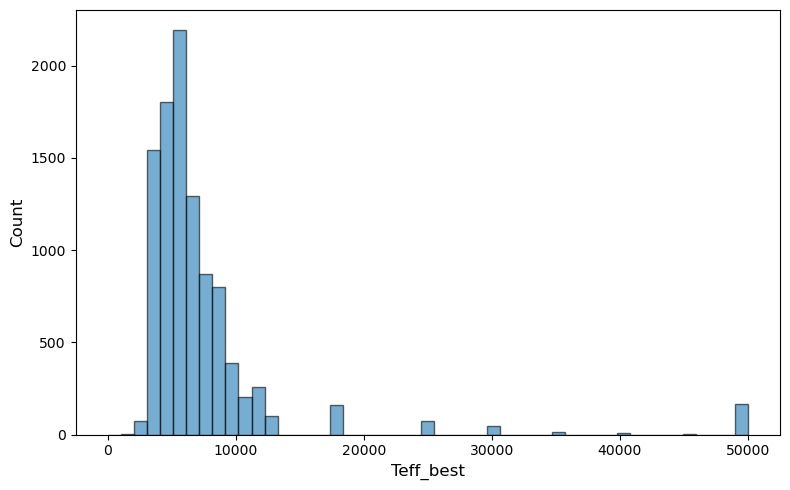

In [15]:
from lephare import statsplot as lsp

best_fit_distribution = sample_analyzer.best_fit_distribution()
lsp.histograms(best_fit_distribution, col='Teff_best', xrange=(-1,max(best_fit_distribution['Teff_best'])), bins=50, log=False)
# lsp.histograms(training_sample, col='npeaks_Teff', xrange=(-1,max(training_sample['npeaks_Teff'])), bins=50, log=False)

## JOIN TABLE

In [7]:
import pandas as pd

def join_tables(base_df, tables, how="outer", ignore=None, put_match_first=True, drop_unmatched=True, indicator=False):
    """
    Join multiple dataframes onto a base dataframe using specified column mappings,
    with options to reorder columns and remove unmatched rows.

    Parameters
    ----------
    base_df : pd.DataFrame
        The initial dataframe to join others onto.

    tables : tuple or list of tuples
        Each tuple must be (other_df, base_col, other_col).

    how : str
        Join type ("left", "right", "inner", "outer").

    ignore : list[str]
        List of columns to drop.

    put_match_first : bool
        If True, the match key (base_col) is moved to the first column.

    drop_unmatched : bool
        If True, rows where the join key has no match are dropped
        (forces an inner-join behavior even if how != "inner").

    indicator : bool
        If True, return the base_df wtih a joint column present filled with 0 for sources
        present only in the base_df, and 1 if present in both table, according to the matching column.
    
    Returns
    -------
    pd.DataFrame
    """
    # Normalize single join instruction to list
    if isinstance(tables, tuple) and len(tables) == 3:
        tables = [tables]

    result = base_df.copy()
    match_columns = []

    for other_df, base_col, other_col in tables:
        result = result.merge(
            other_df,
            how=how,
            left_on=base_col,
            right_on=other_col,
            indicator=indicator
        )
        match_columns.append(base_col)
    # Drop unmatched rows (forces inner join behavior)
    if drop_unmatched:
        for col in match_columns:
            result = result[result[col].notna()]
    
    if indicator:
        result = result[(result['_merge'] == 'left_only') | (result['_merge'] == 'both')]
        result["present"] = (result['_merge'] == "both").astype(int)
        result = result.drop(columns=["_merge"])
    # Drop ignored columns
    if ignore:
        result = result.drop(columns=[c for c in ignore if c in result.columns])

    # Move match columns to front
    if put_match_first:
        # Keep order if multiple match columns
        front_cols = [c for c in match_columns if c in result.columns]
        other_cols = [c for c in result.columns if c not in front_cols]
        result = result[front_cols + other_cols]

    return result


In [74]:
dp02_dc2_62_table = pd.read_csv('/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/DC2/dp02_dc2_62.csv')

In [88]:
mask = (dp02_dc2_62_table['gmag'] > 26) & (dp02_dc2_62_table['gmag'] < 26.5)# & (dp02_dc2_62_table['ymag']/dp02_dc2_62_table['ymag_err'] > 10) & (dp02_dc2_62_table['ymag']/dp02_dc2_62_table['ymag_err'] >10)
dp02_dc2_62_table = dp02_dc2_62_table[mask]
dp02_dc2_62_table

,mt_id_truth_type,mt_match_objectId,ts_ra,ts_dec,ts_truth_type,ts_is_pointsource,ts_redshift,obj_coord_ra,obj_coord_dec,obj_refExtendedness,...,rmag,imag,zmag,ymag,umag_err,gmag_err,rmag_err,imag_err,zmag_err,ymag_err
6,7943780948_1,1651413688361451723,61.826612,-36.523895,1,0,1.583830,61.826611,-36.523902,0.0,...,27.333583,26.705990,26.398789,25.543027,0.380385,0.124979,0.152746,0.286760,0.821362,1.714336
9,7942562735_1,1651413688361450766,61.844052,-36.529150,1,0,1.406630,61.844022,-36.529129,1.0,...,25.974539,25.917630,26.159017,26.046129,0.413118,0.140450,0.166759,0.319610,0.841113,1.636874
10,7940842505_1,1651413688361451066,61.859192,-36.528446,1,0,1.154780,61.859138,-36.528392,1.0,...,25.851665,25.438122,25.044936,24.067170,0.418396,0.140842,0.167538,0.320672,0.846876,1.674169
13,7942718973_1,1651413688361450740,61.903016,-36.528031,1,0,1.437470,61.902887,-36.528072,1.0,...,26.332223,26.133419,25.888708,25.566566,0.499038,0.157934,0.187917,0.355593,1.007639,1.843035
17,7950589486_1,1651413688361453159,61.928577,-36.505945,1,0,2.086610,61.928627,-36.506055,1.0,...,26.157247,25.702481,25.263595,25.202766,0.548811,0.195578,0.222130,0.429290,1.129935,2.067757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389065,7945971524_1,1651272950873103265,62.273288,-36.882354,1,0,1.886960,62.273288,-36.882345,0.0,...,26.161667,25.774863,26.351267,25.431100,0.281887,0.096197,0.114500,0.228259,0.622695,1.264901
389070,7955960915_1,1651220174314977187,62.213952,-37.017651,1,0,2.681180,62.214032,-37.017644,1.0,...,27.510237,26.969542,25.300774,25.188242,0.571689,0.202121,0.237668,0.414618,1.175442,2.318055
389071,7940582447_1,1651281746966091289,62.011337,-36.882398,1,0,1.128350,62.011325,-36.882352,1.0,...,25.882442,25.263101,24.483385,24.522755,0.598621,0.193445,0.207123,0.400970,1.203121,2.033192
389073,7937556894_1,1651343319617242060,62.214016,-36.764291,1,0,0.223015,62.214047,-36.764303,0.0,...,25.648740,25.602706,25.165273,25.539307,0.324876,0.109264,0.125137,0.245820,0.677128,1.428278


In [89]:
training_sample = join_tables(training_sample_features, [(dp02_dc2_62_table[['mt_match_objectId', 'ts_truth_type']], 'source_id', 'mt_match_objectId')], how='right')

In [90]:
training_sample[training_sample['ts_truth_type']==2]

,source_id,npeaks_Teff,peakratio_Teff,std_Teff,npeaks_logg,peakratio_logg,std_logg,npeaks_FeH,peakratio_FeH,std_FeH,...,cov_logg_FeH_yy,cov_logg_FeH_xy,axisratio_logg_FeH,area_logg_FeH_p50,area_logg_FeH_p90,entropy,concentration_dchi2_1,delta_chi2,mt_match_objectId,ts_truth_type
1401,1.651238e+18,1.0,0.030402,681.402521,1.0,0.881164,1.642429,0.0,0.762442,1.034815,...,1.053632,-0.028310,1.541907,0.767544,0.118421,5.761988,0.331059,0.00091,1651237766501016263,2
1407,1.651238e+18,1.0,0.013735,241.491871,3.0,0.419654,1.263347,0.0,0.301279,0.819583,...,0.667779,0.217327,1.674431,0.039474,0.004386,4.617227,0.163945,0.76910,1651237766501005897,2
1509,1.651238e+18,1.0,0.018617,291.010458,2.0,0.817723,1.708111,1.0,0.916592,1.068345,...,1.047010,0.336569,1.687625,0.635965,0.092105,4.748446,0.452311,0.00270,1651237766501008819,2
1643,1.651238e+18,1.0,0.042073,3206.012789,1.0,0.907877,1.642739,0.0,0.808776,1.049837,...,1.092102,-0.031955,1.542873,0.912281,0.153509,6.099356,0.370791,0.00870,1651237766501012244,2
2044,1.567974e+18,1.0,0.023649,442.643301,1.0,0.895437,1.685590,0.0,0.843047,1.023274,...,1.070692,0.074951,1.638818,0.855263,0.096491,5.170700,0.372787,0.00051,1567973949952800764,2
2072,1.567974e+18,1.0,0.011175,298.608000,1.0,0.434293,1.122120,0.0,0.289117,0.982654,...,1.327806,0.265230,1.221872,0.048246,0.004386,4.506088,0.291921,0.23510,1567973949952800299,2
2307,1.651238e+18,1.0,0.012217,257.425068,1.0,0.758967,1.508967,0.0,0.534737,0.922254,...,0.781346,0.086159,1.682532,0.307018,0.039474,4.570318,0.434671,0.00620,1651237766500979397,2
2745,1.651247e+18,1.0,0.011651,236.381667,1.0,0.490430,1.079111,0.0,0.312264,0.671632,...,0.586977,0.173207,1.496745,0.070175,0.017544,4.029457,0.359477,0.09883,1651246562594036375,2


## SPLIT training

A optional step to determine the thresholds of our selection function. 

In [8]:
import numpy as np
import pandas as pd

class SPLIT:
    """
    Prototype classification :
    - Normalisation (mean,std)
    - prototype = mean z-score
    - use_variance : distance chi2-like
    """

    def __init__(self, training_table, label_column,
                 ignore_columns=None, select_columns=None, use_variance=False):

        self.label_column = label_column
        self.use_variance = bool(use_variance)


        # --- 1) Detect columns for which it will compute features -----------------------
        if select_columns is not None:
            if select_columns is None:
                select_columns = []
            all_cols = [c for c in training_table.columns
                        if c in select_columns
                        and c != label_column]
        else:
            if ignore_columns is None:
                ignore_columns = []
            all_cols = [c for c in training_table.columns
                        if c not in ignore_columns
                        and c != label_column]

        self.feature_columns = all_cols

        # --- 2) extract x and y ------------------------------------------------
        X = training_table[self.feature_columns].values.astype(float)
        y = training_table[label_column].values

        # --- 3) global normalisation ------------------------
        self.mu_global = np.nanmean(X, axis=0)
        self.std_global = np.nanstd(X, axis=0)
        # prevent /0
        self.std_global[self.std_global == 0] = 1.0

        # normalise X
        Z = (X - self.mu_global) / self.std_global

        # --- 4) save subtables by type ---------------------------
        self.class_labels = np.unique(y)
        self.class_Z = {cl: Z[y == cl] for cl in self.class_labels}

        # prototypes to be filled later
        self.prototypes_mean = {}
        self.prototypes_var = {}

    # -------------------------------------------------------------------------
    def compute_class_prototypes(self):
        """
        Prototype = mean z-score
        """
        for cl in self.class_labels:
            Zc = self.class_Z[cl]
            if cl == 2:
                print(Zc)
            # moyenne par classe
            self.prototypes_mean[cl] = np.nanmean(Zc, axis=0)

            if self.use_variance:
                # variance par classe (pour distance chi2-like)
                var = np.nanvar(Zc, axis=0)
                var[var == 0] = 1.0  # sécurité
                self.prototypes_var[cl] = var
        return self.prototypes_mean

    # -------------------------------------------------------------------------
    def classify(self, new_table, return_distances=False):
        """
        Classifie une table et renvoie une copie du DataFrame
        avec une colonne 'source_type' ajoutée.

        return_distances=True → ajoute aussi une colonne par classe : dist_<class>
        """
        df = new_table.copy()

        # extrait features
        X = df[self.feature_columns].values.astype(float)

        # normalisation
        Z = (X - self.mu_global) / self.std_global

        # distances
        N = len(Z)
        dist = {cl: np.zeros(N) for cl in self.class_labels}

        for cl in self.class_labels:
            proto = self.prototypes_mean[cl]

            if not self.use_variance:
                dist[cl] = np.nansum((Z - proto)**2, axis=1)
            else:
                var = self.prototypes_var[cl]
                dist[cl] = np.nansum((Z - proto)**2 / var, axis=1)

        # classe prédite
        predicted = np.array([min(dist, key=lambda c: dist[c][i])
                            for i in range(N)])

        # ajoute à la table
        df["source_type"] = predicted

        # Ajoute distances optionnellement
        if return_distances:
            for cl in self.class_labels:
                df[f"dist_{cl}"] = dist[cl]

        return df



In [97]:
split = SPLIT(training_sample, 'ts_truth_type',
                ignore_columns=['source_id', 'mt_match_objectId', 'npeaks_Teff', 'npeaks_logg', 'npeaks_FeH'], use_variance=True)

In [98]:
split.compute_class_prototypes()

[[ 3.04020688e-02  6.81402521e+02  8.81163818e-01  1.64242909e+00
   7.62441948e-01  1.03481528e+00  3.58660051e+05  2.42741406e+00
   7.03748670e+01  3.85485802e+02  1.94892473e-02  4.70430108e-03
   4.21724855e+05  1.07735406e+00  1.47533829e+02  6.41203159e+02
   1.86757216e-02  2.12224109e-03  2.50311810e+00  1.05363213e+00
  -2.83102663e-02  1.54190655e+00  7.67543860e-01  1.18421053e-01
   5.76198805e+00  3.31059410e-01  9.10000000e-04]
 [ 1.37354176e-02  2.41491871e+02  4.19653636e-01  1.26334650e+00
   3.01279461e-01  8.19583042e-01  7.09392993e+04  1.61250112e+00
  -2.59577733e+01  2.10366397e+02  4.03225806e-03  6.72043011e-04
   8.20806848e+04  6.83988216e-01  3.33799185e+00  3.46448972e+02
   1.69779287e-03  4.24448217e-04  1.70624199e+00  6.67778890e-01
   2.17327079e-01  1.67443058e+00  3.94736842e-02  4.38596491e-03
   4.61722723e+00  1.63944894e-01  7.69100000e-01]
 [ 1.86169316e-02  2.91010458e+02  8.17722502e-01  1.70811083e+00
   9.16592147e-01  1.06834526e+00  6.702

{np.int64(1): array([ 1.11827874e-01,  3.30288203e+03,  7.33572148e-01,  1.55299564e+00,
         8.01900644e-01,  1.02113011e+00,  1.84075758e+07,  2.28441538e+00,
         5.87020209e+02,  2.32117279e+03,  4.60966715e-02,  9.78311528e-03,
         2.29669883e+07,  1.05152429e+00,  4.66529946e+01,  3.11283688e+03,
         8.87681540e-02,  2.55877885e-02,  2.43473322e+00,  1.04698554e+00,
        -2.05253283e-03,  1.58412779e+00,  6.36100701e-01,  1.49303858e-01,
         5.81738796e+00,  3.85772376e-01,  6.19324051e-02]),
 np.int64(2): array([ 2.04399310e-02,  7.06871959e+02,  7.00693049e-01,  1.45655176e+00,
         5.96031712e-01,  9.46549369e-01,  6.63058878e+05,  2.15753032e+00,
        -1.56827712e+01,  3.68939990e+02,  1.15927419e-02,  3.36021505e-03,
         1.50857977e+06,  9.32447311e-01,  5.32892938e+01,  7.29265647e+02,
         1.03989813e-02,  1.91001698e-03,  2.15823900e+00,  9.53417941e-01,
         1.36647209e-01,  1.56085032e+00,  4.54495614e-01,  6.57894737e-02,
 

In [ ]:
splitted = split.classify(training_sample)

In [100]:
splitted[splitted['ts_truth_type'] == 2]

,source_id,npeaks_Teff,peakratio_Teff,std_Teff,npeaks_logg,peakratio_logg,std_logg,npeaks_FeH,peakratio_FeH,std_FeH,...,cov_logg_FeH_xy,axisratio_logg_FeH,area_logg_FeH_p50,area_logg_FeH_p90,entropy,concentration_dchi2_1,delta_chi2,mt_match_objectId,ts_truth_type,source_type
1401,1.651238e+18,1.0,0.030402,681.402521,1.0,0.881164,1.642429,0.0,0.762442,1.034815,...,-0.028310,1.541907,0.767544,0.118421,5.761988,0.331059,0.00091,1651237766501016263,2,1
1407,1.651238e+18,1.0,0.013735,241.491871,3.0,0.419654,1.263347,0.0,0.301279,0.819583,...,0.217327,1.674431,0.039474,0.004386,4.617227,0.163945,0.76910,1651237766501005897,2,1
1509,1.651238e+18,1.0,0.018617,291.010458,2.0,0.817723,1.708111,1.0,0.916592,1.068345,...,0.336569,1.687625,0.635965,0.092105,4.748446,0.452311,0.00270,1651237766501008819,2,1
1643,1.651238e+18,1.0,0.042073,3206.012789,1.0,0.907877,1.642739,0.0,0.808776,1.049837,...,-0.031955,1.542873,0.912281,0.153509,6.099356,0.370791,0.00870,1651237766501012244,2,1
2044,1.567974e+18,1.0,0.023649,442.643301,1.0,0.895437,1.685590,0.0,0.843047,1.023274,...,0.074951,1.638818,0.855263,0.096491,5.170700,0.372787,0.00051,1567973949952800764,2,1
2072,1.567974e+18,1.0,0.011175,298.608000,1.0,0.434293,1.122120,0.0,0.289117,0.982654,...,0.265230,1.221872,0.048246,0.004386,4.506088,0.291921,0.23510,1567973949952800299,2,1
2307,1.651238e+18,1.0,0.012217,257.425068,1.0,0.758967,1.508967,0.0,0.534737,0.922254,...,0.086159,1.682532,0.307018,0.039474,4.570318,0.434671,0.00620,1651237766500979397,2,1
2745,1.651247e+18,1.0,0.011651,236.381667,1.0,0.490430,1.079111,0.0,0.312264,0.671632,...,0.173207,1.496745,0.070175,0.017544,4.029457,0.359477,0.09883,1651246562594036375,2,1


In [102]:
len(splitted[(splitted['ts_truth_type'] ==1) & (splitted['source_type'] == 2)])

0

## SPLIT main

## Plots

# DP1

In [9]:
chi2_DP1_values_path = "/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/DP1/PDFs/DP1_buzzard_BT_LSST_full_PDFstar.prob"
chi2_DP1_values = np.loadtxt(chi2_DP1_values_path, max_rows=100000)

/tmp/ipykernel_22016/2571331678.py:2: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=100000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  chi2_DP1_values = np.loadtxt(chi2_DP1_values_path, max_rows=100000)


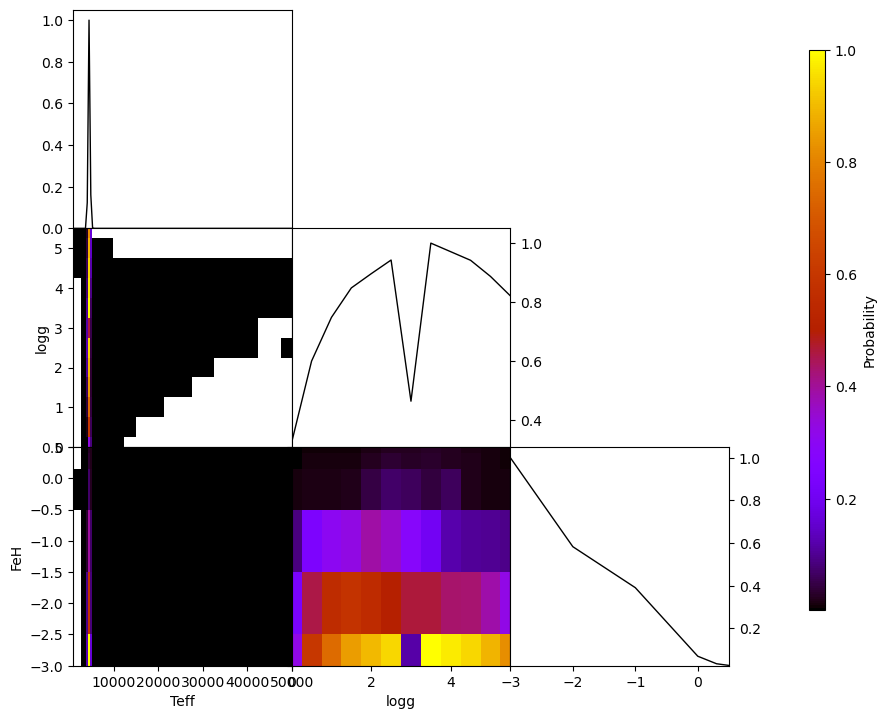

In [10]:
star_pdf_DP1 = STAR_PDF(sed_grid_init)
chi2_grid_DP1 = star_pdf_DP1.build_chi2_grid(chi2_DP1_values[65,1:])
star_pdf_DP1.plot_min_chi2(to_prob=True, full=True)#, fixed={"FeH": 0.5, "Teff": 7200})

[[ 0.0000e+00  1.0200e+04  0.0000e+00 -1.0000e+00  2.5127e+02]
 [ 1.0000e+00  1.0200e+04  0.0000e+00 -2.0000e+00  2.4783e+02]
 [ 2.0000e+00  1.0200e+04  0.0000e+00 -3.0000e+00  2.4738e+02]
 ...
 [ 1.6190e+03  9.6000e+03  5.0000e+00  0.0000e+00  2.8385e+02]
 [ 1.6200e+03  9.6000e+03  5.0000e+00  3.0000e-01  2.8476e+02]
 [ 1.6210e+03  9.6000e+03  5.0000e+00  5.0000e-01  2.8418e+02]]


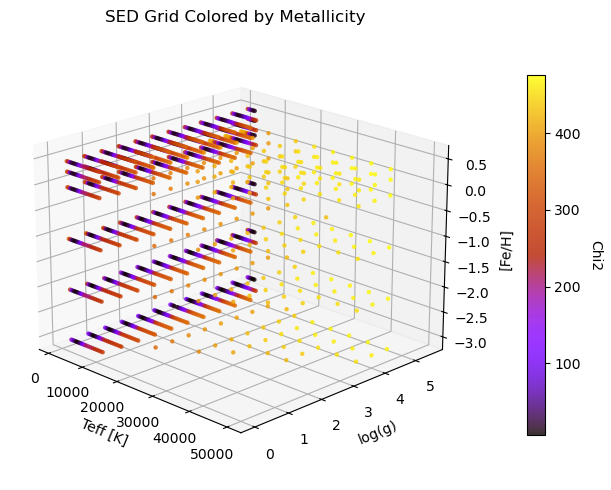

In [11]:
star_pdf_DP1.plot_full_chi2()

In [12]:
sample_analyzer_DP1 = SAMPLE_ANALYZER(chi2_DP1_values_path, sed_grid_path, nrow=5000)
training_sample_features_DP1 = sample_analyzer_DP1.stat_feature_distribution()

/tmp/ipykernel_22016/4078819759.py:12: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=5000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt(chi2_path, max_rows=nrow, dtype=str)


/home/hallouin/Documents/t_hall/lephare/src/lephare/statsplot.py:556: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


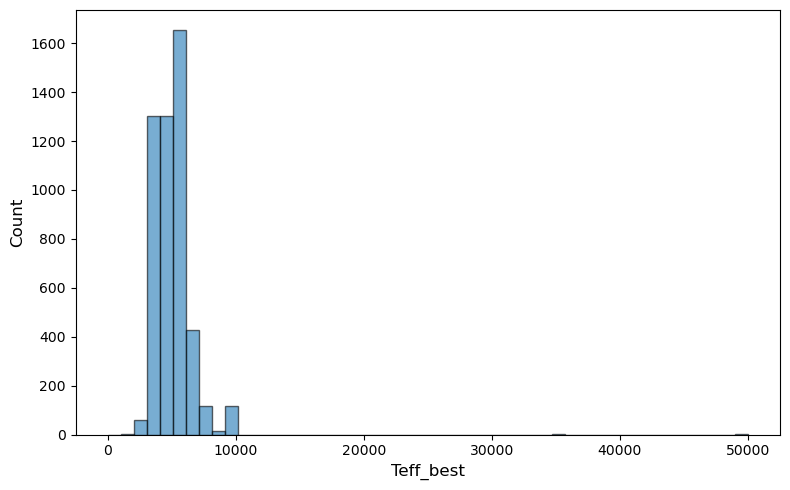

In [13]:
from lephare import statsplot as lsp

best_fit_distribution_DP1 = sample_analyzer_DP1.best_fit_distribution()
lsp.histograms(best_fit_distribution_DP1, col='Teff_best', xrange=(-1,max(best_fit_distribution_DP1['Teff_best'])), bins=50, log=False)
# lsp.histograms(training_sample, col='npeaks_Teff', xrange=(-1,max(training_sample['npeaks_Teff'])), bins=50, log=False)

In [74]:
dp1ECDFS_stars = pd.read_csv('/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/DP1/DP1_ECDFS_star_photometry.csv')

In [75]:
# mask = (dp1ECDFS_stars['g_psfMag'] > 22) & (dp1ECDFS_stars['g_psfMag'] < 24) & dp1ECDFS_stars['u_psfMag'] # & (dp02_dc2_62_table['ymag']/dp02_dc2_62_table['ymag_err'] > 10) & (dp02_dc2_62_table['ymag']/dp02_dc2_62_table['ymag_err'] >10)
mask_nan = ((dp1ECDFS_stars['u_psfMag']) >0) & ((dp1ECDFS_stars['y_psfMag']) >0) & (dp1ECDFS_stars['g_psfMag'] > 24)
dp1ECDFS_stars = dp1ECDFS_stars[mask_nan]
dp1ECDFS_stars

,objectId,coord_ra,coord_dec,ebv,u_psfMag,u_psfMagErr,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,...,i_psfMag0,ug,gr,gi,ri,gi_sdss,gr_sdss,u_sdss,log_teff,feh
72,609788186691909928,53.225451,-28.624961,0.008481,23.349199,0.267366,24.085199,0.042584,23.674299,0.042717,...,23.415083,-0.745301,0.402765,0.639070,0.236305,0.685610,0.447486,23.474881,NaN,NaN
78,609788186691909688,53.143705,-28.627784,0.009504,24.644899,0.860432,24.281099,0.044247,22.825399,0.020338,...,21.705683,0.353378,1.446584,2.540627,1.094043,2.710768,1.612388,24.781538,NaN,NaN
85,609788186691908849,53.202281,-28.642145,0.008857,23.428101,0.286491,24.695601,0.085961,23.509399,0.046360,...,23.110810,-1.277213,1.177705,1.552368,0.374663,1.658272,1.312319,23.502731,NaN,NaN
89,609788186691909229,53.192588,-28.635949,0.009003,29.768700,99.502197,25.434601,0.153031,23.972099,0.065060,...,22.167711,4.324226,1.453866,3.233935,1.780069,3.449141,1.620515,30.026832,NaN,NaN
92,609788186691911285,53.200478,-28.602962,0.008782,25.067801,1.302560,24.200899,0.034809,22.864599,0.016112,...,21.856666,0.857271,1.327876,2.312087,0.984211,2.467373,1.479910,25.181885,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4598,611254522886499524,52.866583,-28.182228,0.009385,26.142300,0.667709,25.834700,0.060788,25.657700,0.065247,...,25.032927,0.297308,0.167998,0.767418,0.599420,0.822301,0.185486,26.250411,NaN,NaN
4599,611254522886499520,52.860133,-28.181124,0.009357,29.530100,14.453400,26.399599,0.102837,25.851999,0.078737,...,25.247383,3.120239,0.538624,1.117963,0.579339,1.195631,0.599105,29.612676,NaN,NaN
4603,611254522886497710,52.851637,-28.184123,0.009355,24.819099,0.189820,24.019199,0.011953,22.784800,0.004864,...,21.772189,0.789641,1.225426,2.212766,0.987339,2.361595,1.365576,24.921213,NaN,NaN
4605,611254522886499280,52.751592,-28.157196,0.009138,25.529100,0.423458,24.852800,0.029093,23.521799,0.011936,...,21.663735,0.666279,1.322236,3.155616,1.833380,3.365731,1.473616,25.770101,NaN,NaN


In [76]:
training_sample_DP1 = join_tables(training_sample_features_DP1, [(dp1ECDFS_stars[['objectId']], 'source_id', 'objectId')], indicator=True, drop_unmatched=False)

In [77]:
training_sample_DP1[training_sample_DP1['present'] == 1]

,source_id,npeaks_Teff,peakratio_Teff,std_Teff,npeaks_logg,peakratio_logg,std_logg,npeaks_FeH,peakratio_FeH,std_FeH,...,cov_logg_FeH_yy,cov_logg_FeH_xy,axisratio_logg_FeH,area_logg_FeH_p50,area_logg_FeH_p90,entropy,concentration_dchi2_1,delta_chi2,objectId,present
2658,6.112535e+17,1.0,0.008065,1.682254e-02,1.0,0.083333,0.000126,1.0,0.053535,0.025051,...,2.755921e-03,-6.086058e-03,7.316211,0.004386,0.004386,3.747991e-08,1.000000,40.30600,6.112535e+17,1
2722,6.112535e+17,1.0,0.008065,3.113677e-51,2.0,0.115886,0.898878,1.0,0.052639,0.002381,...,2.220141e-11,2.655661e-15,162.129353,0.004386,0.004386,5.938047e-01,0.719100,1.88000,6.112535e+17,1
3488,6.112542e+17,1.0,0.008087,2.085275e+01,1.0,0.093760,0.293873,1.0,0.063288,0.102965,...,4.251557e-02,-3.682063e-01,38.902298,0.008772,0.004386,4.216842e-01,0.888798,4.76100,6.112542e+17,1
4364,6.112542e+17,1.0,0.008065,4.055444e-07,1.0,0.083352,0.008046,1.0,0.054084,0.032740,...,4.759084e-03,1.468624e-02,760.528550,0.004386,0.004386,2.135094e-03,0.999778,16.94200,6.112542e+17,1
4585,6.112542e+17,1.0,0.032214,6.302023e+02,2.0,0.813610,1.581502,1.0,0.927319,1.065082,...,1.095531e+00,-3.067989e-02,1.516435,0.916667,0.171053,5.467870e+00,0.549832,0.10710,6.112542e+17,1
4671,6.112542e+17,1.0,0.013387,2.437191e+02,3.0,0.748741,1.613905,1.0,0.691840,1.086488,...,1.135108e+00,1.946280e-01,1.607649,0.508772,0.035088,4.711765e+00,0.275722,0.00053,6.112542e+17,1


In [83]:
split_DP1 = SPLIT(training_sample_DP1, 'present',# select_columns=['entropy', 'concentration_dchi2_1'],
                ignore_columns=['source_id', 'objectId', 'mt_match_objectId', 'npeaks_Teff', 'npeaks_logg', 'npeaks_FeH', 'delta_chi2'], use_variance=False)

In [84]:
split_DP1.compute_class_prototypes()

{np.int64(0): array([ 2.30217362e-04,  2.93253784e-04,  1.08608540e-03,  1.43505123e-03,
         7.99202924e-04,  1.28660452e-03,  2.01541475e-04,  1.26361017e-03,
         1.57407724e-04,  1.74479117e-05,  2.47486600e-04,  2.07916815e-04,
         2.05937091e-04,  8.57551707e-04,  3.35553368e-04,  1.71624101e-05,
         2.02224594e-04,  1.86090646e-04,  7.55944718e-04,  9.05803503e-04,
         1.42909360e-04,  2.36940754e-05,  4.02276250e-04,  3.95708407e-04,
         1.23393320e-03, -1.06968252e-03]),
 np.int64(1): array([-0.19161758, -0.2440849 , -0.90398508, -1.19444098, -0.66520323,
        -1.07088383, -0.16774969, -1.05174486, -0.1310157 , -0.01452248,
        -0.20599135, -0.1730561 , -0.17140831, -0.71376887, -0.27929225,
        -0.01428485, -0.16831827, -0.15488945, -0.62919799, -0.75393045,
        -0.11894822, -0.01972137, -0.33482793, -0.3293613 , -1.02704373,
         0.89033242])}

In [85]:
splitted_DP1 = split_DP1.classify(training_sample_DP1)

In [87]:
len(splitted_DP1[(splitted_DP1['present'] ==1) & (splitted_DP1['source_type'] == 1)])

4

## Teff en FeH estimation efficiency

Test to compare the Teff en FeH estimation efficiency of two methods

In [88]:
dp1ECDFS_stars = pd.read_csv('/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/DP1/DP1_ECDFS_star_photometry.csv')

In [89]:
intrinsic_property_tables = join_tables(dp1ECDFS_stars, [(best_fit_distribution_DP1, 'objectId', 'source_id')])

In [90]:
intrinsic_property_tables_bis = intrinsic_property_tables[(intrinsic_property_tables['FeH_best']>0) & (intrinsic_property_tables['feh']>0)]

In [91]:
intrinsic_property_tables['log_teff']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
9317         NaN
9318    3.699807
9344         NaN
9378         NaN
9386         NaN
Name: log_teff, Length: 4612, dtype: float64

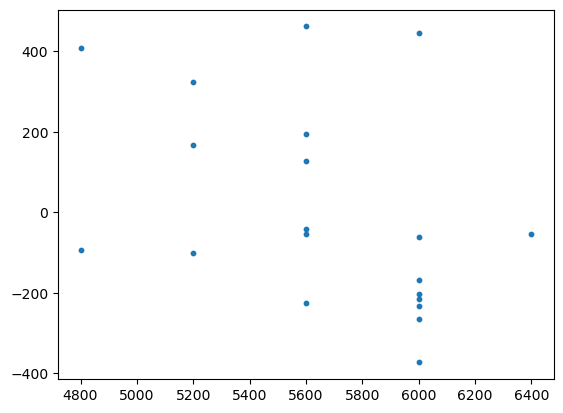

In [92]:
plt.figure()
plt.scatter(intrinsic_property_tables['Teff_best'], intrinsic_property_tables['Teff_best']-10**intrinsic_property_tables['log_teff'], s=10)
# plt.scatter(intrinsic_property_tables['FeH_best'], intrinsic_property_tables['FeH_best']-intrinsic_property_tables['feh'],s=10)
plt.show()

### TRASH

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter


class STAR_PDF_ANALYZER:
    """
    Analyse a chi2_grid (Nx5 array: [Id, Teff, logg, FeH, Chi2])
    and extract a vector of features useful to discriminate star vs galaxy.

    Usage:
        analyzer = STAR_PDF_ANALYZER(chi2_grid, to_prob=True)
        feats = analyzer.compute_all_features()
    """

    def __init__(self, chi2_grid, to_prob=False):
        # Basic checks
        chi2_grid = np.asarray(chi2_grid)
        if chi2_grid.ndim != 2 or chi2_grid.shape[1] < 5:
            raise ValueError("chi2_grid must be shape (N,>=5) with columns [Id,Teff,logg,FeH,Chi2].")

        self.grid = chi2_grid.copy()
        self.to_prob = bool(to_prob)

        # column indices
        self.col = {"Id": 0, "Teff": 1, "logg": 2, "FeH": 3, "Chi2": 4}

        # precompute basic quantities
        self.chi2_min_global = float(np.nanmin(self.grid[:, self.col["Chi2"]]))
        self.P3 = None  # 3D probability (flattened over grid rows)
        if self.to_prob:
            self._make_prob3d()

    # -------------------------
    # Internal helpers
    # -------------------------
    def _make_prob3d(self):
        """Compute 3D probability P_i = exp(-0.5*(chi2 - chi2_min)) normalized over all grid points."""
        chi2 = self.grid[:, self.col["Chi2"]].astype(float)
        dchi2 = chi2 - np.nanmin(chi2)
        # prevent overflow/underflow
        with np.errstate(over="ignore", invalid="ignore"):
            P = np.exp(-0.5 * dchi2)
        P[np.isnan(P)] = 0.0
        s = P.sum()
        if s <= 0:
            P = np.zeros_like(P)
        else:
            P = P / s
        self.P3 = P
        return P

    def _project_1d(self, axis, to_prob=None, fixed=None):
        """
        Build projected 1D array along axis by taking min_chi2 over other two dims.
        Returns (X_vals_sorted, Z_vals) where Z is either min_chi2 (if to_prob False)
        or normalized probability (if to_prob True).
        fixed: dict of fixed parameters e.g. {"FeH":0.0} to restrict points before projection.
        """
        if to_prob is None:
            to_prob = self.to_prob

        col_idx = self.col[axis]
        # apply fixed mask if any
        mask = np.ones(len(self.grid), dtype=bool)
        if fixed:
            for k, v in fixed.items():
                if k not in self.col:
                    raise ValueError(f"Unknown fixed axis '{k}'")
                mask &= np.isclose(self.grid[:, self.col[k]], v)
        sub = self.grid[mask]
        if sub.size == 0:
            return np.array([]), np.array([])

        X_vals = np.unique(sub[:, col_idx])
        X_vals.sort()
        Z = np.full(len(X_vals), np.nan)
        # For each X, find min chi2 over remaining dims
        for i, xv in enumerate(X_vals):
            sel = np.isclose(sub[:, col_idx], xv)
            if not np.any(sel):
                continue
            Z[i] = np.nanmin(sub[sel, self.col["Chi2"]])

        if to_prob:
            # convert to prob using local min to avoid underflow and normalize
            if np.all(np.isnan(Z)):
                return X_vals, Z
            dchi = Z - np.nanmin(Z)
            with np.errstate(over="ignore", invalid="ignore"):
                P = np.exp(-0.5 * dchi)
            P[np.isnan(P)] = 0.0
            s = P.sum()
            if s > 0:
                P = P / s
            else:
                P = np.zeros_like(P)
            return X_vals, P
        else:
            return X_vals, Z

    def _project_2d(self, xaxis, yaxis, to_prob=None, fixed=None):
        """
        Build projected 2D grid by taking min chi2 over third axis.
        Returns (X_vals_sorted, Y_vals_sorted, Z (shape (len(Y), len(X))))
        Z is min_chi2 if to_prob False, else normalized prob on the 2D grid.
        """
        if to_prob is None:
            to_prob = self.to_prob

        xi = self.col[xaxis]
        yi = self.col[yaxis]
        # third axis
        axes = {"Teff", "logg", "FeH"}
        third = list(axes - {xaxis, yaxis})[0]
        ti = self.col[third]

        mask = np.ones(len(self.grid), dtype=bool)
        if fixed:
            for k, v in fixed.items():
                if k not in self.col:
                    raise ValueError(f"Unknown fixed axis '{k}'")
                mask &= np.isclose(self.grid[:, self.col[k]], v)

        sub = self.grid[mask]
        if sub.size == 0:
            return np.array([]), np.array([]), np.array([[]])

        X_vals = np.unique(sub[:, xi]); X_vals.sort()
        Y_vals = np.unique(sub[:, yi]); Y_vals.sort()

        Z = np.full((len(Y_vals), len(X_vals)), np.nan)

        for i, xv in enumerate(X_vals):
            for j, yv in enumerate(Y_vals):
                sel = np.isclose(sub[:, xi], xv) & np.isclose(sub[:, yi], yv)
                if not np.any(sel):
                    continue
                Z[j, i] = np.nanmin(sub[sel, self.col["Chi2"]])

        if to_prob:
            if np.all(np.isnan(Z)):
                return X_vals, Y_vals, Z
            # convert local to probability and normalize over the grid
            dchi = Z - np.nanmin(Z)
            with np.errstate(over="ignore", invalid="ignore"):
                P = np.exp(-0.5 * dchi)
            P[np.isnan(P)] = 0.0
            s = np.nansum(P)
            if s > 0:
                P = P / s
            else:
                P = np.zeros_like(P)
            return X_vals, Y_vals, P
        else:
            return X_vals, Y_vals, Z

    # -------------------------
    # 1D metrics
    # -------------------------
    def npeaks_1d(self, axis, threshold=0.5, fixed=None):
        """
        Number of significant peaks in 1D projected PDF.
        threshold: fraction of max used for peak detection (height)
        """
        X, Z = self._project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        # operate on Z whether it is prob or chi2 (if chi2, invert to make peaks)
        if self.to_prob:
            arr = Z
            height = threshold * np.nanmax(arr)
            peaks, _ = find_peaks(arr, height=height)
            return int(len(peaks))
        else:
            # invert chi2 to find minima as peaks
            arr = -Z
            height = threshold * np.nanmax(arr)
            peaks, _ = find_peaks(arr, height=height)
            return int(len(peaks))

    def peakratio_1d(self, axis, fixed=None):
        """
        mean(Z) / max(Z) where Z is probability (if to_prob True) or exp(-0.5*(chi2-localmin)) normalized.
        We return (mean/max) which is small for peaked distributions.
        """
        X, Z = self._project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        if np.nanmax(Z) == 0:
            return -99
        return float(np.nanmean(Z) / np.nanmax(Z))

    def std_1d(self, axis, fixed=None):
        """
        Weighted standard deviation of the 1D PDF around its normalized distribution.
        If to_prob=False we convert to prob-like weighting using exp(-0.5*(Z - Zmin)).
        """
        X, Z = self._project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        # if Z is chi2 minima (to_prob False), convert to weights
        if not self.to_prob:
            if np.all(np.isnan(Z)):
                return -99
            dchi = Z - np.nanmin(Z)
            with np.errstate(over="ignore", invalid="ignore"):
                W = np.exp(-0.5 * dchi)
            W[np.isnan(W)] = 0.0
            s = W.sum()
            if s > 0:
                W = W / s
            else:
                W = np.zeros_like(W)
        else:
            W = Z.copy()
        if np.nansum(W) <= 0:
            return -99
        mean = np.nansum(X * W)
        var = np.nansum(((X - mean) ** 2) * W)
        return float(np.sqrt(var))

    # -------------------------
    # 2D metrics
    # -------------------------
    def cov_2d(self, xaxis, yaxis, fixed=None):
        """
        Compute weighted covariance matrix of the 2D projected probability map.
        Returns (cov_xx, cov_yy, cov_xy, axis_ratio) where axis_ratio = sqrt(largest_eig / smallest_eig)
        If to_prob False, will convert projection to probabilities internally.
        """
        X, Y, P = self._project_2d(xaxis, yaxis, to_prob=self.to_prob, fixed=fixed)
        if P.size == 0:
            return (-99, -99, -99, -99)

        # Flatten and compute weighted covariance
        Xg, Yg = np.meshgrid(X, Y)  # shape (len(Y), len(X))
        W = np.array(P, dtype=float)
        W = W / (np.nansum(W) + 1e-300)

        x_flat = Xg.ravel()
        y_flat = Yg.ravel()
        w_flat = W.ravel()

        # Only keep positive weight points
        good = w_flat > 0
        if np.sum(good) == 0:
            return (-99, -99, -99, -99)
        x_flat = x_flat[good]; y_flat = y_flat[good]; w_flat = w_flat[good]

        mean_x = np.sum(x_flat * w_flat)
        mean_y = np.sum(y_flat * w_flat)

        cov_xx = np.sum(w_flat * (x_flat - mean_x) ** 2)
        cov_yy = np.sum(w_flat * (y_flat - mean_y) ** 2)
        cov_xy = np.sum(w_flat * (x_flat - mean_x) * (y_flat - mean_y))

        # eigenvalues of covariance 2x2
        cov_mat = np.array([[cov_xx, cov_xy], [cov_xy, cov_yy]])
        try:
            eigvals = np.linalg.eigvalsh(cov_mat)
            eigvals = np.maximum(eigvals, 1e-300)
            axis_ratio = float(np.sqrt(eigvals[-1] / eigvals[0])) if eigvals[0] > 0 else float(np.inf)
        except Exception:
            axis_ratio = -99

        return float(cov_xx), float(cov_yy), float(cov_xy), float(axis_ratio)

    def area_highprob_2d(self, xaxis, yaxis, threshold=0.5, fixed=None):
        """
        Fraction of (x,y) grid cells where P(x,y) >= threshold * Pmax.
        Returns fraction in [0,1].
        """
        X, Y, P = self._project_2d(xaxis, yaxis, to_prob=self.to_prob, fixed=fixed)
        if P.size == 0:
            return -99.0
        Pmax = np.nanmax(P)
        if Pmax <= 0:
            return 0.0
        mask = P >= (threshold * Pmax)
        # fraction of valid grid cells (consider only non-nan cells)
        valid = ~np.isnan(P)
        if np.sum(valid) == 0:
            return -99.0
        frac = np.sum(mask & valid) / np.sum(valid)
        return float(frac)

    # -------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Global metrics
    # -------------------------
    def entropy(self):
        """
        Entropy of the full 3D probability distribution (in nats).
        H = - sum_i P_i log P_i
        """
        if self.P3 is None:
            self._make_prob3d()
        P = np.array(self.P3, dtype=float)
        # filter zeros
        mask = P > 0
        if np.sum(mask) == 0:
            return -99.0
        H = -np.sum(P[mask] * np.log(P[mask]))
        return float(H)

    def concentration(self, delta_chi2=1.0):
        """
        Fraction of total probability contained in chi2 <= chi2_min_global + delta_chi2.
        """
        chi2 = self.grid[:, self.col["Chi2"]].astype(float)
        if self.P3 is None:
            self._make_prob3d()
        mask = chi2 <= (self.chi2_min_global + float(delta_chi2))
        if np.sum(mask) == 0:
            return 0.0
        return float(np.sum(self.P3[mask]))

    def delta_chi2(self):
        """
        Difference between second-best chi2 and best chi2 (global).
        """
        chi2 = np.array(self.grid[:, self.col["Chi2"]], dtype=float)
        if chi2.size < 2:
            return -99.0
        sorted_chi = np.sort(chi2)
        d = float(sorted_chi[1] - sorted_chi[0])
        return d

    # -------------------------
    # Main orchestrator
    # -------------------------
    def compute_all_features(self, fixed=None):
        """
        Compute a dictionary with all features:
          - 1D: npeaks, peakratio, std  (for Teff, logg, FeH)
          - 2D: covariances and axis_ratio, area_highprob for each pair
          - global: entropy, concentration (delta_chi2=1), delta_chi2
        fixed: optional dict to restrict analysis to a slice before projecting.
        """
        feats = {}

        # 1D features
        for ax in ["Teff", "logg", "FeH"]:
            feats[f"npeaks_{ax}"] = self.npeaks_1d(ax, threshold=0.2, fixed=fixed)
            feats[f"peakratio_{ax}"] = self.peakratio_1d(ax, fixed=fixed)
            feats[f"std_{ax}"] = self.std_1d(ax, fixed=fixed)

        # 2D features: pairs
        pairs = [("Teff", "logg"), ("Teff", "FeH"), ("logg", "FeH")]
        for (x, y) in pairs:
            cov_xx, cov_yy, cov_xy, axis_ratio = self.cov_2d(x, y, fixed=fixed)
            feats[f"cov_{x}_{y}_xx"] = cov_xx
            feats[f"cov_{x}_{y}_yy"] = cov_yy
            feats[f"cov_{x}_{y}_xy"] = cov_xy
            feats[f"axisratio_{x}_{y}"] = axis_ratio
            feats[f"area_{x}_{y}_p50"] = self.area_highprob_2d(x, y, threshold=0.5, fixed=fixed)
            feats[f"area_{x}_{y}_p90"] = self.area_highprob_2d(x, y, threshold=0.9, fixed=fixed)

        # global features
        feats["entropy"] = self.entropy()
        feats["concentration_dchi2_1"] = self.concentration(delta_chi2=1.0)
        feats["delta_chi2"] = self.delta_chi2()

        return feats
